# Projeto 4: Análise de Churn

#Importação de Biliotecas


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,precision_score,recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
import lime
from lime import lime_tabular
from imblearn.over_sampling import SMOTE



#Carregando os Dados

In [2]:
df = pd.read_csv("Churn_treino.csv", sep=";")
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0,1,1,1,10134888,1
1,608,Spain,Female,41,1,8380786,1,0,1,11254258,0
2,502,France,Female,42,8,1596608,3,1,0,11393157,1
3,699,France,Female,39,1,0,2,0,0,9382663,0
4,850,Spain,Female,43,2,12551082,1,1,1,790841,0
5,645,Spain,Male,44,8,11375578,2,1,0,14975671,1
6,822,France,Male,50,7,0,2,1,1,100628,0
7,376,Germany,Female,29,4,11504674,4,1,0,11934688,1
8,501,France,Male,44,4,14205107,2,0,1,749405,0
9,684,France,Male,27,2,13460388,1,1,1,7172573,0


#Análise Gráfica do perfil de Churn

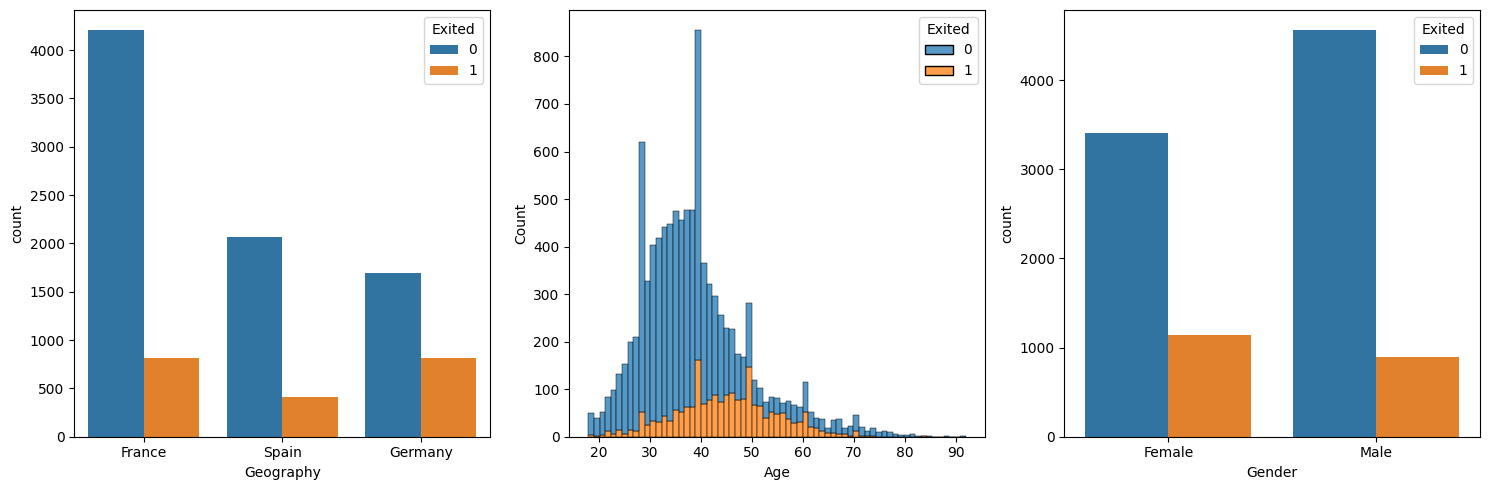

In [3]:
#Distribuição do perfil de "Exit"(Churn) de acordo com Geography, Age e Gender.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x='Geography', hue='Exited', data=df, ax=ax[0])
sns.histplot(data=df, x='Age', hue='Exited', multiple="stack", ax=ax[1])
sns.countplot(x='Gender', hue='Exited', data=df, ax=ax[2])
plt.tight_layout()
plt.show()

#Pré-Processamento

In [4]:
#Definindo as variáveis preditoras e a variável alvo
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [5]:
#Checando valores faltantes
print(df.isnull().sum())

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [6]:
#Padronizando variáveis numéricas para que não contribuam de forma desbalanceada para o modelo
standarscaler = StandardScaler()
numerical = X.select_dtypes(include=['int64','float64']).columns
X[numerical] = standarscaler.fit_transform(X[numerical])
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.326221,France,Female,0.293517,-1.041760,-1.110553,-0.911583,0.646092,0.970243,0.170614
1,-0.440036,Spain,Female,0.198164,-1.387538,0.222782,-0.911583,-1.547768,0.970243,0.353281
2,-1.536794,France,Female,0.293517,1.032908,-0.856542,2.527057,0.646092,-1.030670,0.375948
3,0.501521,France,Female,0.007457,-1.387538,-1.110553,0.807737,-1.547768,-1.030670,0.047859
4,2.063884,Spain,Female,0.388871,-1.041760,0.886252,-0.911583,0.646092,0.970243,-1.354223


In [7]:
#Transformando colunas categóricas em numéricas
labelencoder = LabelEncoder()
categorical = X.select_dtypes(include='object').columns
for col in categorical:
  X[col] = labelencoder.fit_transform(X[col])
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.326221,0,0,0.293517,-1.041760,-1.110553,-0.911583,0.646092,0.970243,0.170614
1,-0.440036,2,0,0.198164,-1.387538,0.222782,-0.911583,-1.547768,0.970243,0.353281
2,-1.536794,0,0,0.293517,1.032908,-0.856542,2.527057,0.646092,-1.030670,0.375948
3,0.501521,0,0,0.007457,-1.387538,-1.110553,0.807737,-1.547768,-1.030670,0.047859
4,2.063884,2,0,0.388871,-1.041760,0.886252,-0.911583,0.646092,0.970243,-1.354223


In [8]:
#Dividindo os dados entre treino e teste, com 70% para treino e 30% para teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X,y, test_size=0.3, random_state=0)

In [9]:
# Checar balanceamento da variável alvo no conjunto de treino
print("Balanceamento da variável alvo antes do oversampling:")
print(y_treino.value_counts())
print(y_treino.value_counts(normalize=True))

# Aplicar oversampling com SMOTE no conjunto de treino
smote = SMOTE(random_state=0)
X_treino_res, y_treino_res = smote.fit_resample(X_treino, y_treino)

# Checar balanceamento da variável alvo após oversampling
print("\nBalanceamento da variável alvo após oversampling:")
print(y_treino_res.value_counts())
print(y_treino_res.value_counts(normalize=True))

Balanceamento da variável alvo antes do oversampling:
Exited
0    5584
1    1416
Name: count, dtype: int64
Exited
0    0.797714
1    0.202286
Name: proportion, dtype: float64

Balanceamento da variável alvo após oversampling:
Exited
1    5584
0    5584
Name: count, dtype: int64
Exited
1    0.5
0    0.5
Name: proportion, dtype: float64


#Modelo de Rede Neural

In [10]:
modelo = Sequential([                     # Cria um modelo sequencial (camadas empilhadas em ordem).
    Input(shape=(X_treino.shape[1],)),    # Define a forma da entrada (número de colunas em X_treino).
    Dense(units=64, activation='relu'),   # Primeira camada densa com 64 neurônios e ativação ReLU.
    Dropout(0.4),                         # "Desliga" 40% dos neurônios dessa camada aleatoriamente (regularização).
    Dense(units=32, activation='relu'),   # Segunda camada densa com 32 neurônios e ativação ReLU.
    Dropout(0.4),                         # Outro dropout de 40% para evitar overfitting.
    Dense(units=64, activation='relu'),   # Terceira camada densa com 64 neurônios e ativação ReLU.
    Dropout(0.4),                         # Dropout novamente com 40% de taxa.
    Dense(units=1, activation='sigmoid')  # Camada de saída com 1 neurônio e ativação sigmoid (para classificação binária).
])


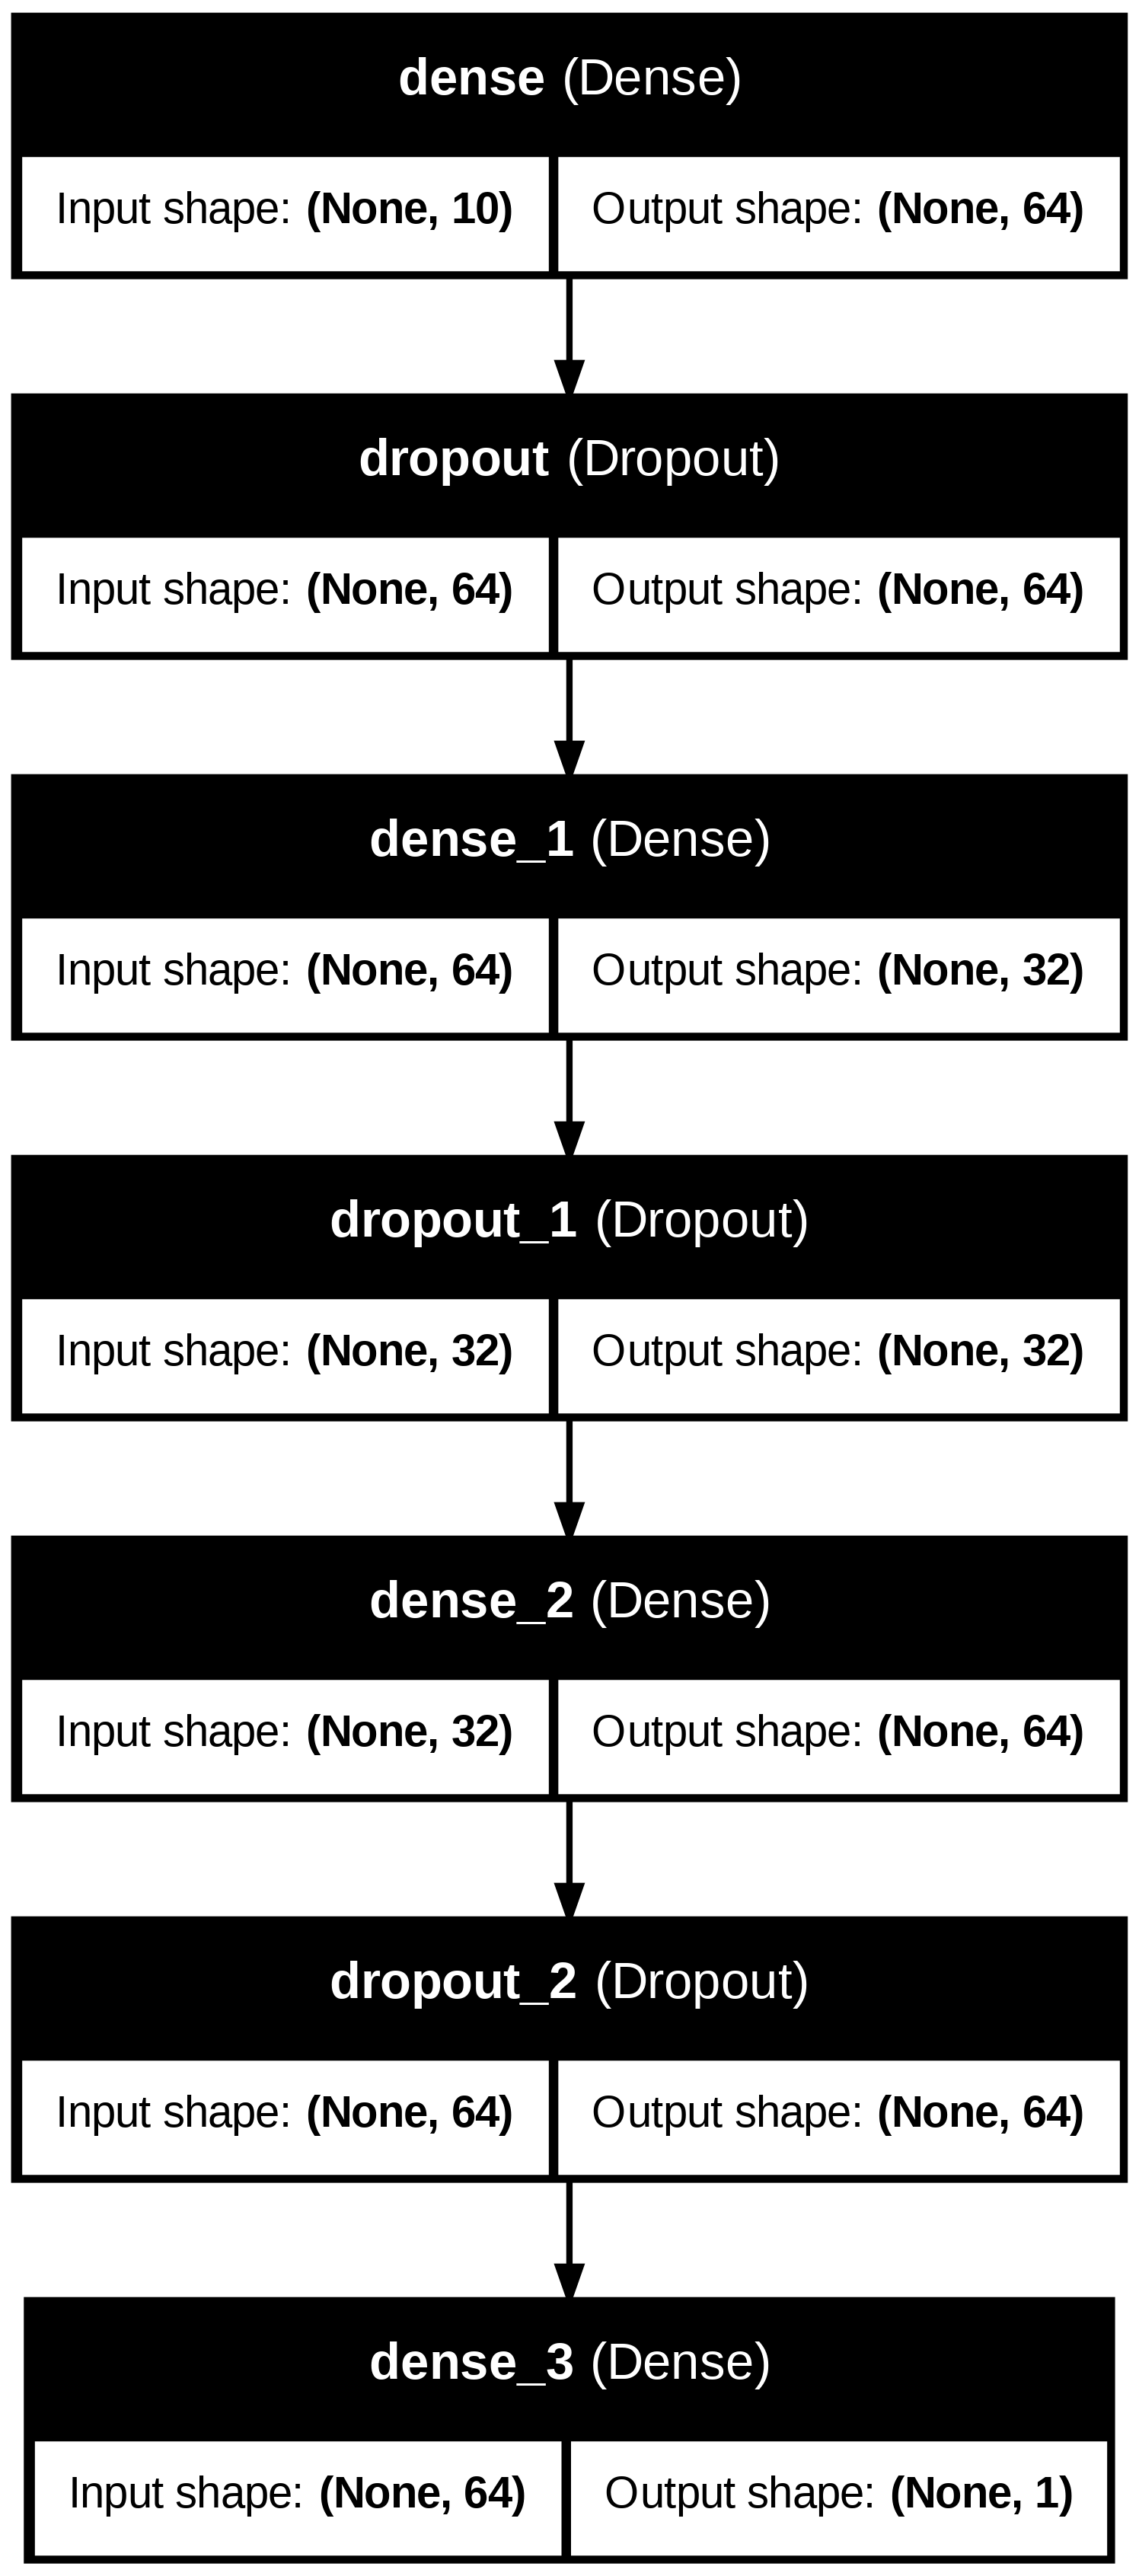

In [11]:
plot_model(modelo, to_file="modelo.png", show_shapes=True, show_layer_names=True, dpi=300)


#Treino

In [12]:
#Treinando o modelo
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo.fit(X_treino, y_treino, epochs=100, batch_size=32)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7783 - loss: 0.5421
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7910 - loss: 0.4738
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7989 - loss: 0.4520
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8083 - loss: 0.4305
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8101 - loss: 0.4321
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8186 - loss: 0.4290
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8291 - loss: 0.4093
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8335 - loss: 0.4024
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8371 - loss: 0.3844
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8499 - loss: 0.3696
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8508 - loss: 0.3732
Epoch 12/100
219/219 ━━━━━━━━━━━━━━━━━━━━

#Previsões

In [13]:
previsoes = modelo.predict(X_teste)
previsoes

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.43095052],
       [0.26116833],
       [0.33708036],
       ...,
       [0.06526302],
       [0.08557358],
       [0.5549473 ]], dtype=float32)

In [14]:
y_pred = (previsoes > 0.5).astype('int32')  # Converte previsões em 0 ou 1: valores > 0.5 viram 1, senão 0
y_pred                                      # Mostra os valores binários previstos (classes finais)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], dtype=int32)

#Métricas

In [15]:
#Dicionário com as métricas do modelo

metrics = {
    'Acurácia': accuracy_score(y_teste, y_pred),
    'F1-Score': f1_score(y_teste, y_pred),
    'Precisão': precision_score(y_teste, y_pred),
    'Recall': recall_score(y_teste, y_pred)
}
print("Métricas de Avaliação")
for metric, value in metrics.items():
  print(f"{metric}: {value}")

Métricas de Avaliação
Acurácia: 0.8606666666666667
F1-Score: 0.5760649087221096
Precisão: 0.7780821917808219
Recall: 0.4573268921095008


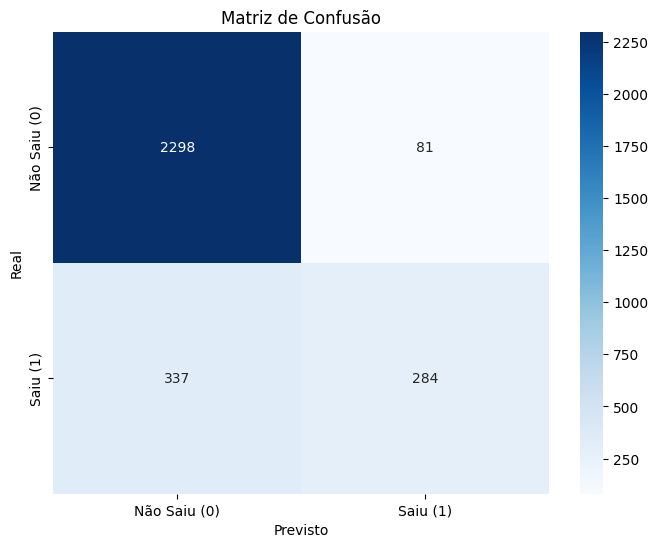

In [16]:
#Criando a matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

#Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Regressão Logística

In [17]:
# Criando o modelo de Regressão Logística
modelo_logistico = LogisticRegression(random_state=0)

# Treinando o modelo com os dados de treino
modelo_logistico.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_logistico = modelo_logistico.predict(X_teste)

# Calculando as métricas para o modelo de Regressão Logística
metrics_logistico = {
    'Acurácia': accuracy_score(y_teste, y_pred_logistico),
    'F1-Score': f1_score(y_teste, y_pred_logistico),
    'Precisão': precision_score(y_teste, y_pred_logistico),
    'Recall': recall_score(y_teste, y_pred_logistico)
}

print("\nMétricas de Avaliação para Regressão Logística")
for metric, value in metrics_logistico.items():
  print(f"{metric}: {value}")



Métricas de Avaliação para Regressão Logística
Acurácia: 0.8033333333333333
F1-Score: 0.26616915422885573
Precisão: 0.5846994535519126
Recall: 0.1723027375201288


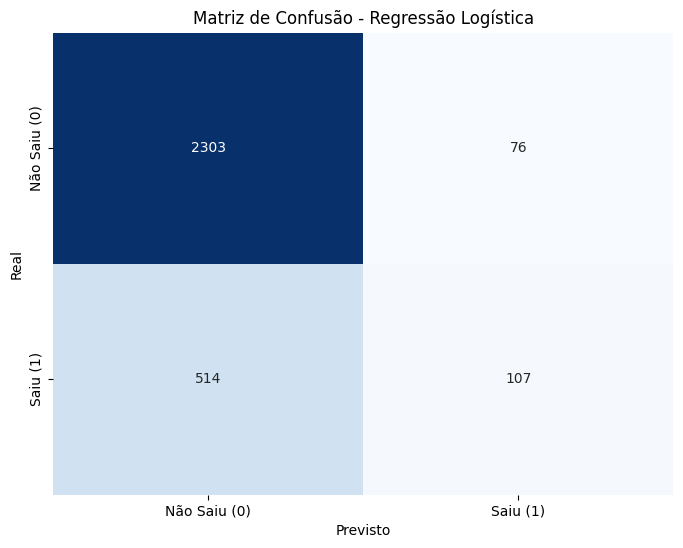

In [18]:
#Gerando a matriz de confusão para o modelo de Regressão Logística
cm_logistico = confusion_matrix(y_teste, y_pred_logistico)

#Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistico, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

# Random Forest

In [19]:
# Criando o modelo de Random Forest
modelo_rf = RandomForestClassifier(random_state=0)

# Treinando o modelo com os dados de treino
modelo_rf.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_rf = modelo_rf.predict(X_teste)

# Calculando as métricas para o modelo de Random Forest
metrics_rf = {
    'Acurácia': accuracy_score(y_teste, y_pred_rf),
    'F1-Score': f1_score(y_teste, y_pred_rf),
    'Precisão': precision_score(y_teste, y_pred_rf),
    'Recall': recall_score(y_teste, y_pred_rf)
}

print("\nMétricas de Avaliação para Random Forest")
for metric, value in metrics_rf.items():
  print(f"{metric}: {value}")




Métricas de Avaliação para Random Forest
Acurácia: 0.8616666666666667
F1-Score: 0.5951219512195122
Precisão: 0.754950495049505
Recall: 0.49114331723027377


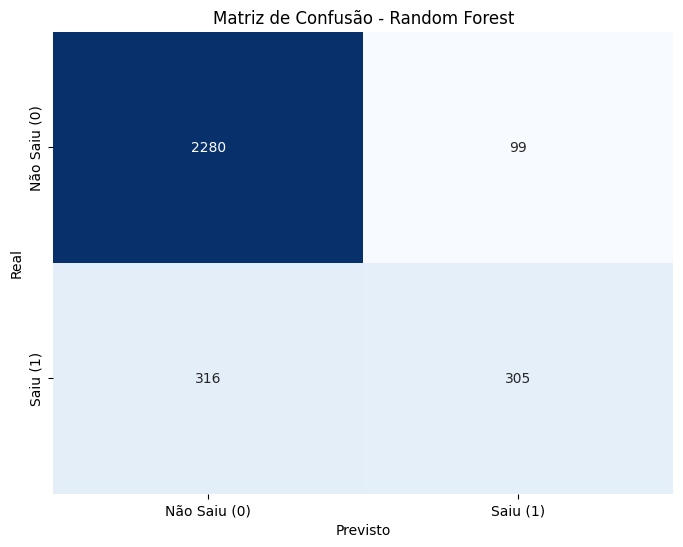

In [20]:
# Gerando a matriz de confusão para o modelo de Random Forest
cm_rf = confusion_matrix(y_teste, y_pred_rf)
# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

#Naive Bayes

In [21]:
# Criando o modelo Naive Bayes (GaussianNB para dados numéricos)
modelo_nb = GaussianNB()

# Treinando o modelo com os dados de treino
modelo_nb.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_nb = modelo_nb.predict(X_teste)

# Calculando as métricas para o modelo Naive Bayes
metrics_nb = {
    'Acurácia': accuracy_score(y_teste, y_pred_nb),
    'F1-Score': f1_score(y_teste, y_pred_nb),
    'Precisão': precision_score(y_teste, y_pred_nb),
    'Recall': recall_score(y_teste, y_pred_nb)
}

print("\nMétricas de Avaliação para Naive Bayes")
for metric, value in metrics_nb.items():
  print(f"{metric}: {value}")



Métricas de Avaliação para Naive Bayes
Acurácia: 0.822
F1-Score: 0.3657957244655582
Precisão: 0.6968325791855203
Recall: 0.24798711755233493


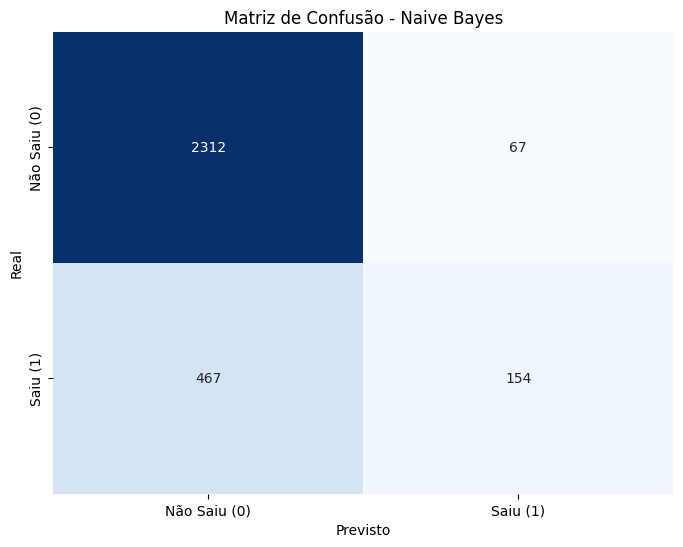

In [22]:
# Gerando a matriz de confusão para o modelo Naive Bayes
cm_nb = confusion_matrix(y_teste, y_pred_nb)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()

#SVM

In [23]:
# Criando o modelo SVM (Support Vector Machine)
modelo_svm = SVC(random_state=0)

# Treinando o modelo com os dados de treino
modelo_svm.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_svm = modelo_svm.predict(X_teste)

# Calculando as métricas para o modelo SVM
metrics_svm = {
    'Acurácia': accuracy_score(y_teste, y_pred_svm),
    'F1-Score': f1_score(y_teste, y_pred_svm),
    'Precisão': precision_score(y_teste, y_pred_svm),
    'Recall': recall_score(y_teste, y_pred_svm)
}

print("\nMétricas de Avaliação para SVM")
for metric, value in metrics_svm.items():
  print(f"{metric}: {value}")



Métricas de Avaliação para SVM
Acurácia: 0.8633333333333333
F1-Score: 0.5591397849462365
Precisão: 0.8414239482200647
Recall: 0.41867954911433175


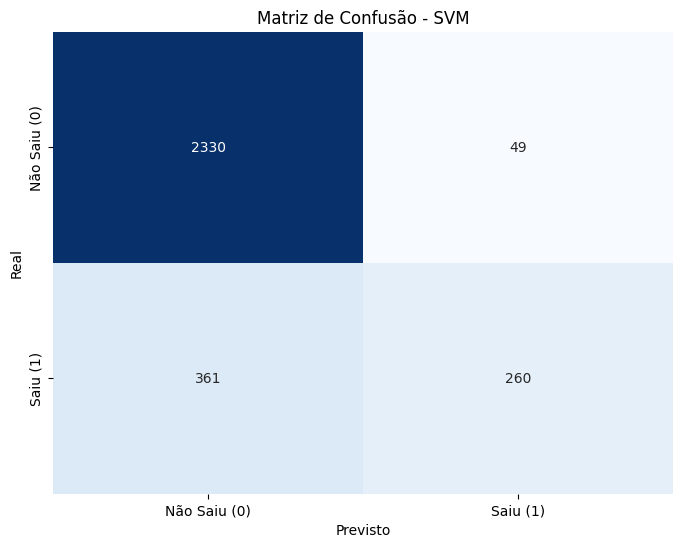

In [24]:
# Gerando a matriz de confusão para o modelo SVM
cm_svm = confusion_matrix(y_teste, y_pred_svm)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - SVM')
plt.show()


#AdaBoost

In [25]:
# Criando o modelo AdaBoost
modelo_ada = AdaBoostClassifier(random_state=0)

# Treinando o modelo com os dados de treino
modelo_ada.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_ada = modelo_ada.predict(X_teste)

# Calculando as métricas para o modelo AdaBoost
metrics_ada = {
    'Acurácia': accuracy_score(y_teste, y_pred_ada),
    'F1-Score': f1_score(y_teste, y_pred_ada),
    'Precisão': precision_score(y_teste, y_pred_ada),
    'Recall': recall_score(y_teste, y_pred_ada)
}

print("\nMétricas de Avaliação para AdaBoost")
for metric, value in metrics_ada.items():
  print(f"{metric}: {value}")



Métricas de Avaliação para AdaBoost
Acurácia: 0.856
F1-Score: 0.5877862595419847
Precisão: 0.7213114754098361
Recall: 0.49597423510466987


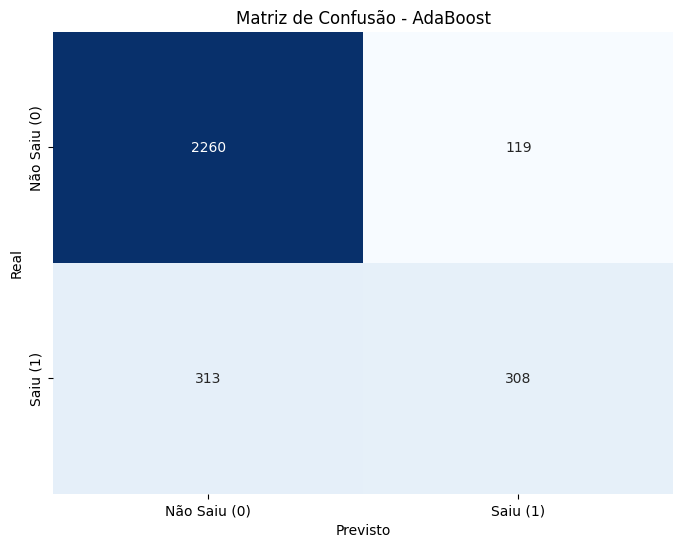

In [26]:
# Gerando a matriz de confusão para o modelo AdaBoost
cm_ada = confusion_matrix(y_teste, y_pred_ada)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - AdaBoost')
plt.show()


#XGBoost

In [27]:
# Criando o modelo XGBoost
modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# Treinando o modelo com os dados de treino
modelo_xgb.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_xgb = modelo_xgb.predict(X_teste)

# Calculando as métricas para o modelo XGBoost
metrics_xgb = {
    'Acurácia': accuracy_score(y_teste, y_pred_xgb),
    'F1-Score': f1_score(y_teste, y_pred_xgb),
    'Precisão': precision_score(y_teste, y_pred_xgb),
    'Recall': recall_score(y_teste, y_pred_xgb)
}

print("\nMétricas de Avaliação para XGBoost")
for metric, value in metrics_xgb.items():
  print(f"{metric}: {value}")


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:57:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Métricas de Avaliação para XGBoost
Acurácia: 0.8543333333333333
F1-Score: 0.5949953660797034
Precisão: 0.7008733624454149
Recall: 0.5169082125603864


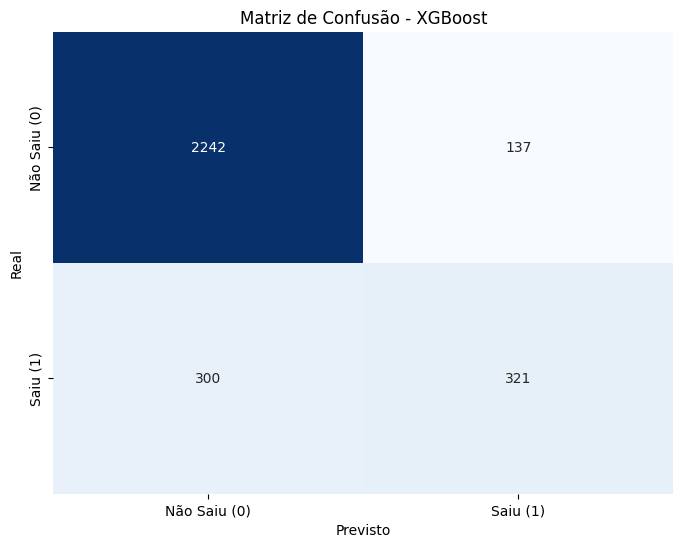

In [28]:
# Gerando a matriz de confusão para o modelo XGBoost
cm_xgb = confusion_matrix(y_teste, y_pred_xgb)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - XGBoost')
plt.show()


#KNN

In [29]:
# Criando o modelo KNN
# OBS: podemos experimentar diferentes valores para n_neighbors (o número de vizinhos)
modelo_knn = KNeighborsClassifier(n_neighbors=5)

# Treinando o modelo com os dados de treino
modelo_knn.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_knn = modelo_knn.predict(X_teste)

# Calculando as métricas para o modelo KNN
metrics_knn = {
    'Acurácia': accuracy_score(y_teste, y_pred_knn),
    'F1-Score': f1_score(y_teste, y_pred_knn),
    'Precisão': precision_score(y_teste, y_pred_knn),
    'Recall': recall_score(y_teste, y_pred_knn)
}

print("\nMétricas de Avaliação para KNN")
for metric, value in metrics_knn.items():
  print(f"{metric}: {value}")



Métricas de Avaliação para KNN
Acurácia: 0.8233333333333334
F1-Score: 0.482421875
Precisão: 0.6129032258064516
Recall: 0.3977455716586151


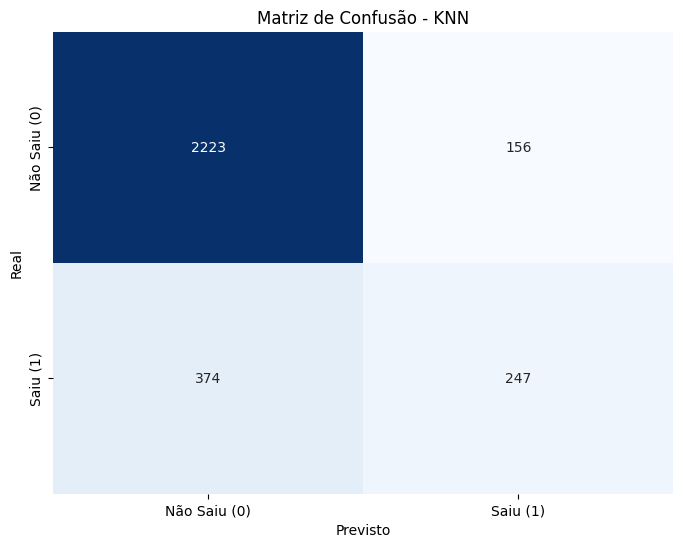

In [30]:
# Gerando a matriz de confusão para o modelo KNN
cm_knn = confusion_matrix(y_teste, y_pred_knn)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - KNN')
plt.show()


#LightGBM

In [31]:
# Criando o modelo LightGBM
modelo_lgbm = lgb.LGBMClassifier(random_state=0)

# Treinando o modelo com os dados de treino
modelo_lgbm.fit(X_treino, y_treino)

# Realizando previsões com os dados de teste
y_pred_lgbm = modelo_lgbm.predict(X_teste)

# Calculando as métricas para o modelo LightGBM
metrics_lgbm = {
    'Acurácia': accuracy_score(y_teste, y_pred_lgbm),
    'F1-Score': f1_score(y_teste, y_pred_lgbm),
    'Precisão': precision_score(y_teste, y_pred_lgbm),
    'Recall': recall_score(y_teste, y_pred_lgbm)
}

print("\nMétricas de Avaliação para LightGBM")
for metric, value in metrics_lgbm.items():
  print(f"{metric}: {value}")

[LightGBM] [Info] Number of positive: 1416, number of negative: 5584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202286 -> initscore=-1.372069
[LightGBM] [Info] Start training from score -1.372069

Métricas de Avaliação para LightGBM
Acurácia: 0.8603333333333333
F1-Score: 0.6087768440709617
Precisão: 0.7244444444444444
Recall: 0.5249597423510467


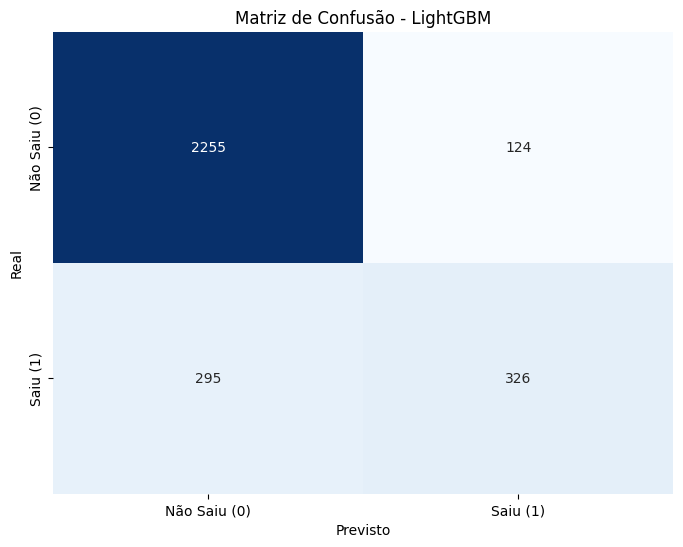

In [32]:
# Gerando a matriz de confusão para o modelo LightGBM
cm_lgbm = confusion_matrix(y_teste, y_pred_lgbm)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Saiu (0)', 'Saiu (1)'], yticklabels=['Não Saiu (0)', 'Saiu (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - LightGBM')
plt.show()


Economia Potencial de Churn com LightGBM (assumindo retenção de todos os TP): R$32600.00


#Tabela de Comparação de Métricas

In [33]:
# Agrupando as métricas em um DataFrame
metricas_agrupadas = pd.DataFrame({
    'Rede Neural': metrics,
    'Regressão Logística': metrics_logistico,
    'Random Forest': metrics_rf,
    'Naive Bayes': metrics_nb,
    'SVM': metrics_svm,
    'AdaBoost': metrics_ada,
    'XGBoost': metrics_xgb,
    'KNN': metrics_knn,
    'LightGBM': metrics_lgbm
})

print("\nTabela Comparativa de Métricas dos Modelos:")
metricas_agrupadas


Tabela Comparativa de Métricas dos Modelos:


,Rede Neural,Regressão Logística,Random Forest,Naive Bayes,SVM,AdaBoost,XGBoost,KNN,LightGBM
Acurácia,0.860667,0.803333,0.861667,0.822000,0.863333,0.856000,0.854333,0.823333,0.860333
F1-Score,0.576065,0.266169,0.595122,0.365796,0.559140,0.587786,0.594995,0.482422,0.608777
Precisão,0.778082,0.584699,0.754950,0.696833,0.841424,0.721311,0.700873,0.612903,0.724444
Recall,0.457327,0.172303,0.491143,0.247987,0.418680,0.495974,0.516908,0.397746,0.524960


#Explicabilidade com LIME do melhor modelo


In [34]:
# LIME
# Criando o explicador LIME
# Passamos o modelo que queremos explicar, os dados de treino, e os nomes das colunas
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_treino),
    feature_names=X_treino.columns.tolist(),
    class_names=['Não Saiu', 'Saiu'],
    mode='classification'
)

# Escolha uma instância para explicar (ex: a primeira instância do conjunto de teste)
instance_idx = 0
instance = X_teste.iloc[instance_idx]

# Obtendo a explicação para a instância escolhida
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=modelo_lgbm.predict_proba,
    num_features=len(X_teste.columns) # Número de features a mostrar na explicação
)

# Visualizando a explicação
print(f"\nExplicação LIME para a instância {instance_idx}:")
explanation.show_in_notebook(show_table=True, show_all=False)


Explicação LIME para a instância 0:


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

# Impacto financeiro do modelo

In [39]:
# Assumindo um valor hipotético de receita média por cliente (em R$)
receita_media_por_cliente = 100

# Obtendo os valores da matriz de confusão do LightGBM
# cm_lgbm[0, 0] é True Negative (TN): Clientes que não saíram e foram previstos como não saindo
# cm_lgbm[0, 1] é False Positive (FP): Clientes que não saíram e foram previstos como saindo
# cm_lgbm[1, 0] é False Negative (FN): Clientes que saíram e foram previstos como não saindo
# cm_lgbm[1, 1] é True Positive (TP): Clientes que saíram e foram previstos como saindo

tn_lgbm = cm_lgbm[0, 0]
fp_lgbm = cm_lgbm[0, 1]
fn_lgbm = cm_lgbm[1, 0]
tp_lgbm = cm_lgbm[1, 1]

# Calculando o número de churners que o modelo identificou corretamente (True Positives)
churners_identificados_lgbm = tp_lgbm

# Calculando a economia potencial: True Positives * Receita Média por Cliente
# Esta é uma estimativa simplificada, pois assume que todos os TP poderiam ser retidos
economia_potencial_lgbm = churners_identificados_lgbm * receita_media_por_cliente

print(f"Economia Potencial de Churn com LightGBM (assumindo retenção de todos os TP): R${economia_potencial_lgbm:.2f}")

Economia Potencial de Churn com LightGBM (assumindo retenção de todos os TP): R$32600.00
